Epoch [1/500], Loss: 1.6099
Epoch [5/500], Loss: 1.5569
Epoch [10/500], Loss: 1.4579
Epoch [15/500], Loss: 1.4226
Epoch [20/500], Loss: 1.4270
Epoch [25/500], Loss: 1.4079
Epoch [30/500], Loss: 1.4078
Epoch [35/500], Loss: 1.4079
Epoch [40/500], Loss: 1.4222
Epoch [45/500], Loss: 1.4046
Epoch [50/500], Loss: 1.4065
Epoch [55/500], Loss: 1.3945
Epoch [60/500], Loss: 1.3893
Epoch [65/500], Loss: 1.3859
Epoch [70/500], Loss: 1.3813
Epoch [75/500], Loss: 1.3766
Epoch [80/500], Loss: 1.3703
Epoch [85/500], Loss: 1.3844
Epoch [90/500], Loss: 1.3729
Epoch [95/500], Loss: 1.3620
Epoch [100/500], Loss: 1.3720
Epoch [105/500], Loss: 1.3889
Epoch [110/500], Loss: 1.3798
Epoch [115/500], Loss: 1.3659
Epoch [120/500], Loss: 1.3704
Epoch [125/500], Loss: 1.3436
Epoch [130/500], Loss: 1.3560
Epoch [135/500], Loss: 1.3609
Epoch [140/500], Loss: 1.3493
Epoch [145/500], Loss: 1.3383
Epoch [150/500], Loss: 1.3347
Epoch [155/500], Loss: 1.3449
Epoch [160/500], Loss: 1.3388
Epoch [165/500], Loss: 1.3277
Ep

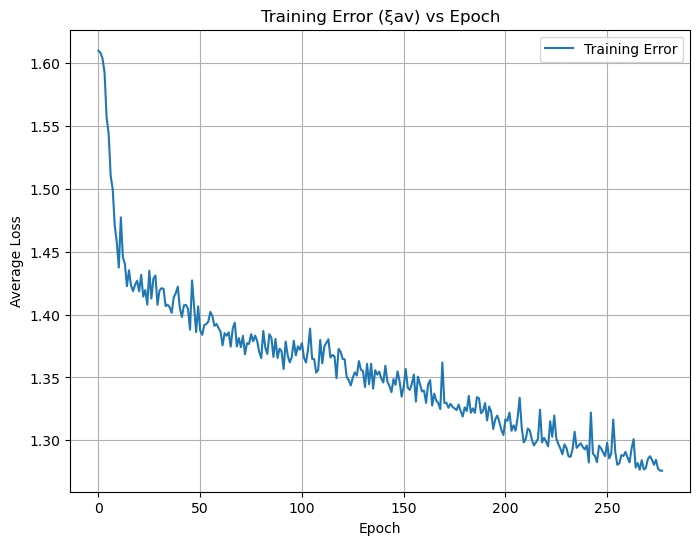

Train Accuracy: 64.62%
Validation Accuracy: 44.00%
Test Accuracy: 46.50%


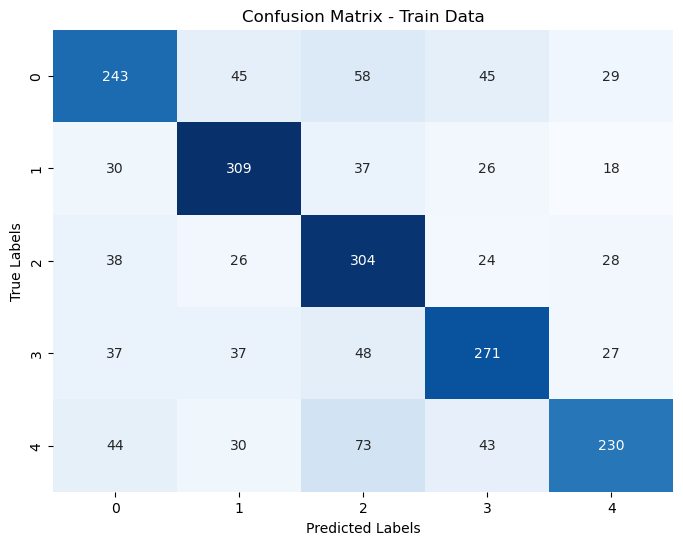

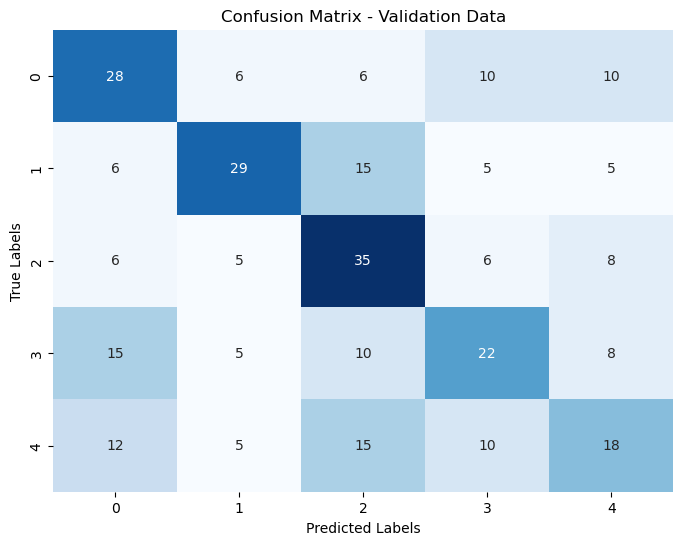

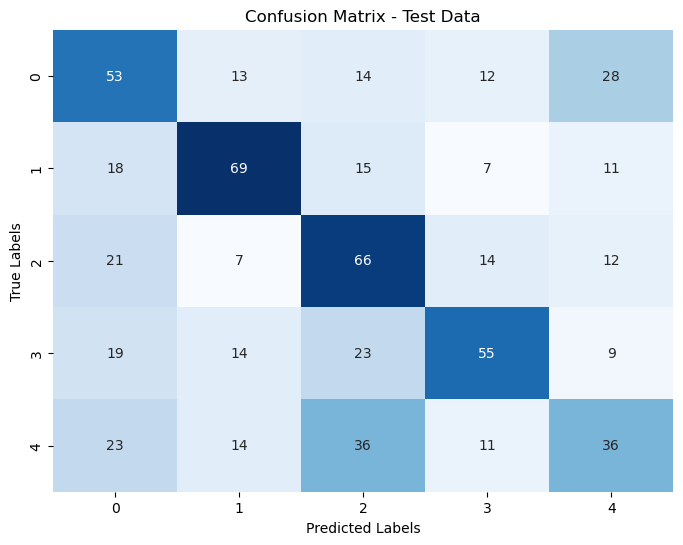

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV files
train_data = pd.read_csv('Dataset-3/train_data.csv', header=None)
train_label = pd.read_csv('Dataset-3/train_label.csv', header=None)
val_data = pd.read_csv('Dataset-3/val_data.csv', header=None)
val_label = pd.read_csv('Dataset-3/val_label.csv', header=None)
test_data = pd.read_csv('Dataset-3/test_data.csv', header=None)
test_label = pd.read_csv('Dataset-3/test_label.csv', header=None)

# Apply PCA
pca = PCA(n_components=20)
train_data_pca = pca.fit_transform(train_data)
val_data_pca = pca.transform(val_data)
test_data_pca = pca.transform(test_data)

# Min-Max Normalization
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data_pca)
val_data_normalized = scaler.transform(val_data_pca)
test_data_normalized = scaler.transform(test_data_pca)

# Convert to tensors
train_data_tensor = torch.tensor(train_data_normalized, dtype=torch.float32)
train_label_tensor = torch.tensor(train_label.values.flatten(), dtype=torch.long)

val_data_tensor = torch.tensor(val_data_normalized, dtype=torch.float32)
val_label_tensor = torch.tensor(val_label.values.flatten(), dtype=torch.long)

test_data_tensor = torch.tensor(test_data_normalized, dtype=torch.float32)
test_label_tensor = torch.tensor(test_label.values.flatten(), dtype=torch.long)

# Dataset and DataLoader
batch_size = 32
train_dataset = TensorDataset(train_data_tensor, train_label_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_data_tensor, val_label_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(test_data_tensor, test_label_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the MLFFNN model
class MLFFNN(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

# Instantiate the model
input_size = 20
hidden1_size = 25
hidden2_size = 15
output_size = 5
model = MLFFNN(input_size, hidden1_size, hidden2_size, output_size)

# Define hyperparameters
learning_rate = 0.07
momentum = 0.9
threshold = 0.0001

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# Training function
def train_model(model, train_loader, optimizer, criterion, num_epochs=500):
    model.train()
    loss_list = []
    epoch_list = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_list.append(avg_loss)
        epoch_list.append(epoch)

        if epoch > 0 and abs(loss_list[-1] - loss_list[-2]) < threshold:
            print(f"Converged after {epoch} epochs")
            break
        if epoch==0 or (epoch+1)%5==0 :
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    plot_training_error(epoch_list, loss_list)

# Plot function for training error
def plot_training_error(epochs, losses):
    plt.figure(figsize=(8,6))
    plt.plot(epochs, losses, label="Training Error")
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Error (ξav) vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train the model
train_model(model, train_loader, optimizer, criterion)

# Function to evaluate the model and return predictions
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect all labels and predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = (correct / total) * 100
    return accuracy, all_labels, all_preds

# Confusion matrix plotting function
def plot_confusion_matrix(true_labels, predicted_labels, title):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

# Evaluate and plot confusion matrices for train, validation, and test data
train_accuracy, train_labels, train_preds = evaluate_model(model, train_loader)
val_accuracy, val_labels, val_preds = evaluate_model(model, val_loader)
test_accuracy, test_labels, test_preds = evaluate_model(model, test_loader)

print(f'Train Accuracy: {train_accuracy:.2f}%')
print(f'Validation Accuracy: {val_accuracy:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot confusion matrices
plot_confusion_matrix(train_labels, train_preds, "Train Data")
plot_confusion_matrix(val_labels, val_preds, "Validation Data")
plot_confusion_matrix(test_labels, test_preds, "Test Data")